In [ ]:
! pip install scikit-plot

In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, ZeroPadding2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
DATA_PATH = "/kaggle/input/fyp-dataset/feralignedck/feraligned+ck/"
TOP_EMOTIONS = ["Angry", "Fear", "Happy", "Neutral", "Sadness", "Surprise"]

TRAIN_SIZE = 0.80
INPUT_SHAPE = (64,64,1)
NUM_CLASSES = len(TOP_EMOTIONS)

In [ ]:
total_images = 0
for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        count = 0
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of images")
        total_images += count

print(f"\ntotal images are {total_images}")

Surprise has 249 number of images
Fear has 728 number of images
Angry has 938 number of images
Neutral has 1230 number of images
Sadness has 1153 number of images
Happy has 2203 number of images

total images are 6501


In [ ]:
img_arr = []
img_label = []
label_to_text = {}
label = 0

for dir_ in os.listdir(DATA_PATH):
    if dir_ in TOP_EMOTIONS:
        for f in os.listdir(DATA_PATH + dir_ + "/"):
            img = cv2.imread(DATA_PATH + dir_ + "/" + f, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (64, 64))  # Resize the image to 64x64
            img_arr.append(np.expand_dims(img, axis=2))
            img_label.append(label)
        print(f"loaded {dir_} images to numpy arrays...")
        label_to_text[label] = dir_
        label += 1

img_arr = np.array(img_arr)
img_label = np.array(img_label)
img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

img_arr.shape, img_label.shape, label_to_text

loaded Surprise images to numpy arrays...
loaded Fear images to numpy arrays...
loaded Angry images to numpy arrays...
loaded Neutral images to numpy arrays...
loaded Sadness images to numpy arrays...
loaded Happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


((6501, 64, 64, 1),
 (6501, 6),
 {0: 'Surprise',
  1: 'Fear',
  2: 'Angry',
  3: 'Neutral',
  4: 'Sadness',
  5: 'Happy'})

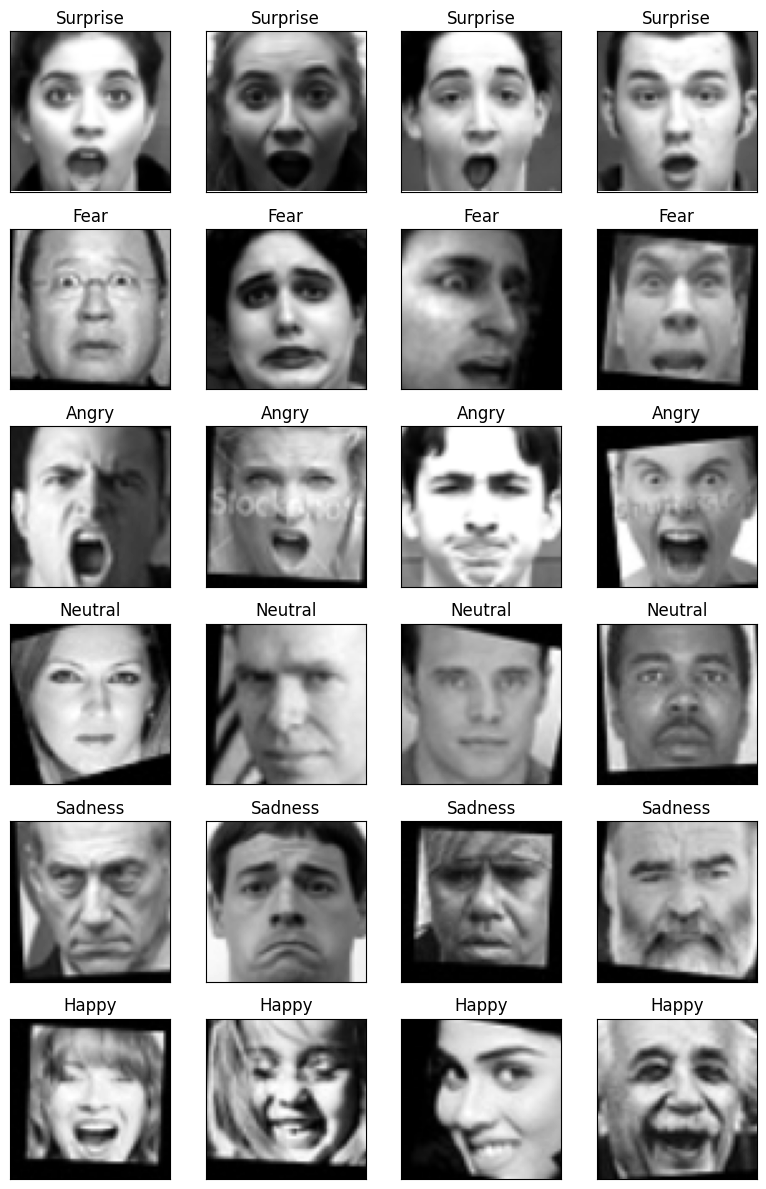

In [ ]:
num_emotions = len(TOP_EMOTIONS)
num_cols = 4
fig, axes = pyplot.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text:
    sample_indices = np.random.choice(np.where(img_label[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(64, 64), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text[k])

    idx += 1

pyplot.tight_layout()
pyplot.show()

In [ ]:
img_arr = img_arr / 255.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    train_size=TRAIN_SIZE, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5200, 64, 64, 1), (1301, 64, 64, 1), (5200, 6), (1301, 6))

In [ ]:
def transition_cell(X, filters: int, compression_factor: float, cell_id: int):
    num_fm = X.shape[1]

    X = BatchNormalization(name=f"transition{cell_id}_bn")(X)
    X = Activation('relu', name=f"transition{cell_id}_actv")(X)
    X = Conv2D(
        np.floor(compression_factor * num_fm ).astype(int),
        kernel_size=(1, 1),
        padding='same',
        kernel_initializer=he_normal(seed=42),
        name=f"transition{cell_id}_conv2d",
    )(X)

    X = AveragePooling2D(pool_size=(2, 2), name=f"transition{cell_id}_pool2d")(X)
    return X

In [ ]:
def dense_block(inputs, num_layers: int, filters: int, growth_rate: float, block_id: int):
    layer_id = 1
    for i in range(num_layers):
        X = BatchNormalization(name=f"block{block_id}_bn{layer_id}")(inputs)
        X = Activation('relu', name=f"block{block_id}_actv{layer_id}")(X)
        X = ZeroPadding2D((1, 1), name=f"block{block_id}_pad{layer_id}")(X)
        X = Conv2D(
            filters,
            kernel_size=(3, 3),
            kernel_initializer=he_normal(seed=42),
            name = f"block{block_id}_conv2d{layer_id}"
        )(X)
        inputs = Concatenate(name=f"block{block_id}_concat{layer_id}")([X, inputs])
        filters += growth_rate
        layer_id += 1

    return inputs, filters

In [ ]:
def DenseNet(in_shape, out_shape, num_blocks=3, layers_per_block=3, growth_rate=12,
             compress_factor=0.5, initial_filters=12, dropout_rate=0.3, show_summary=False):

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
        initial_filters,
        kernel_size=(3,3),
        strides = (1,1),
        padding = 'valid',
        kernel_initializer=he_normal(seed=42),
        name = "conv2d_0"
    )(model_in)

    block_id = 1
    num_filters = initial_filters
    for i in range(num_blocks):
        X, num_filters = dense_block(X, layers_per_block, num_filters, growth_rate, block_id=block_id)
        X = transition_cell(X, num_filters, compress_factor, cell_id=block_id)
        block_id += 1

    X = GlobalAveragePooling2D()(X)
    X = Flatten()(X)

    X = Dense(units=128, name="dense1")(X)
    X = BatchNormalization(name = 'dense1_bn')(X)
    X = Activation('relu', name="dense1_actv")(X)

    model_out = Dense(out_shape, activation="softmax")(X)

    model = Model(model_in, model_out)

    if show_summary:
        model.summary()

    return model

In [ ]:
# Define a custom callback for early stopping based on validation accuracy
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_accuracy', patience=10, restore_best_weights=True):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.restore_best_weights = restore_best_weights
        self.best = -np.Inf  # Initialize best to negative infinity
        self.best_epoch = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get(self.monitor)
        if current_val_acc > self.best:
            self.best = current_val_acc
            self.best_epoch = epoch
            self.best_weights = self.model.get_weights()  # Save the best weights
        elif epoch - self.best_epoch >= self.patience:
            print(f"Epoch {epoch}: Early stopping due to no improvement in {self.patience} epochs.")
            self.model.stop_training = True
            if self.restore_best_weights and self.best_weights is not None:
                print(f"Restoring best weights from epoch {self.best_epoch}.")
                self.model.set_weights(self.best_weights)

In [ ]:
model = DenseNet(INPUT_SHAPE, NUM_CLASSES, num_blocks=3, layers_per_block=3, show_summary=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 in_layer (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_0 (Conv2D)           (None, 62, 62, 12)           120       ['in_layer[0][0]']            
                                                                                                  
 block1_bn1 (BatchNormaliza  (None, 62, 62, 12)           48        ['conv2d_0[0][0]']            
 tion)                                                                                            
                                                                                                  
 block1_actv1 (Activation)   (None, 62, 62, 12)           0         ['block1_bn1[0][0]']      

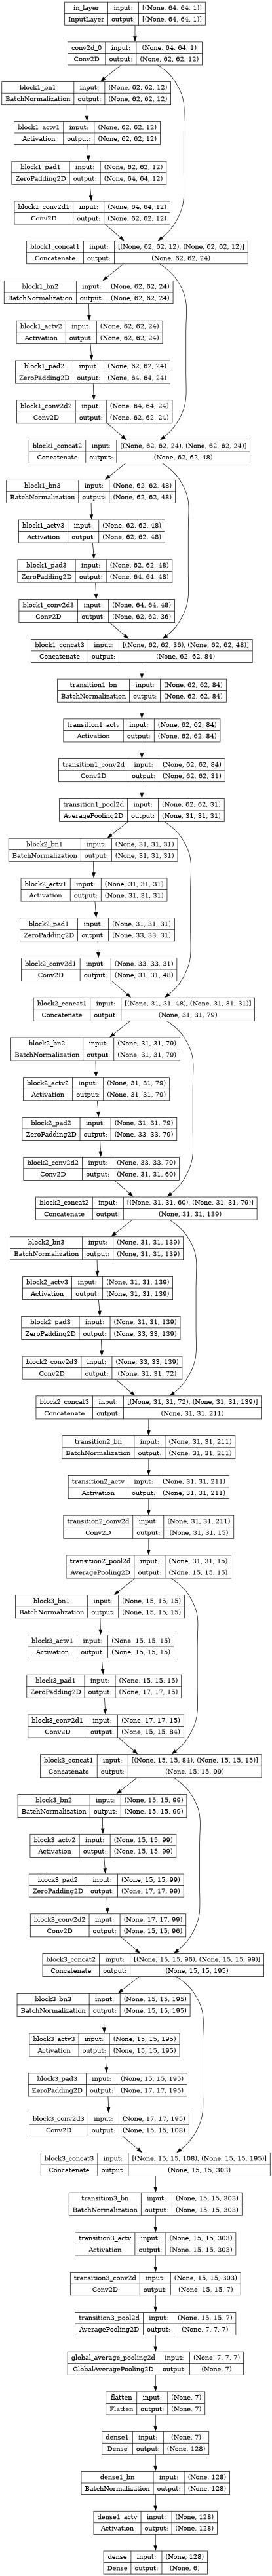

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.1,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=9,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
batch_size = 32
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.001)
epochs = 100

In [ ]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy'],
)

train_datagen.fit(X_train)

custom_early_stopping = CustomEarlyStopping(patience=15)

history_DenseNet = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data = (X_test, y_test),
    steps_per_epoch = len(X_train) / batch_size,
    epochs = epochs,
    callbacks = [lr_scheduler, custom_early_stopping],
)

Epoch 1/100
162/162 [==============================] - 24s 57ms/step - loss: 1.6194 - accuracy: 0.3263 - val_loss: 1.6071 - val_accuracy: 0.3405 - lr: 0.0010
Epoch 2/100
162/162 [==============================] - 7s 45ms/step - loss: 1.5396 - accuracy: 0.3712 - val_loss: 1.5978 - val_accuracy: 0.3121 - lr: 0.0010
Epoch 3/100
162/162 [==============================] - 7s 45ms/step - loss: 1.3869 - accuracy: 0.4410 - val_loss: 1.5192 - val_accuracy: 0.4297 - lr: 0.0010
Epoch 4/100
162/162 [==============================] - 7s 45ms/step - loss: 1.1951 - accuracy: 0.5298 - val_loss: 1.4064 - val_accuracy: 0.4658 - lr: 0.0010
Epoch 5/100
162/162 [==============================] - 7s 45ms/step - loss: 1.0665 - accuracy: 0.5775 - val_loss: 2.8809 - val_accuracy: 0.4089 - lr: 0.0010
Epoch 6/100
162/162 [==============================] - 7s 45ms/step - loss: 0.9937 - accuracy: 0.6050 - val_loss: 1.0325 - val_accuracy: 0.5819 - lr: 0.0010
Epoch 7/100
162/162 [==============================] - 7s

In [ ]:
history = pd.DataFrame(history_DenseNet.history)
history

,loss,accuracy,val_loss,val_accuracy,lr
0,1.619353,0.326346,1.607149,0.340507,1.000000e-03
1,1.539612,0.371154,1.597848,0.312068,1.000000e-03
2,1.386950,0.440962,1.519158,0.429669,1.000000e-03
3,1.195108,0.529808,1.406428,0.465796,1.000000e-03
4,1.066483,0.577500,2.880858,0.408916,1.000000e-03
...,...,...,...,...,...
61,0.568950,0.793269,0.723134,0.739431,1.000000e-07
62,0.584049,0.784038,0.722133,0.743274,1.000000e-07
63,0.576054,0.791731,0.721830,0.742506,1.000000e-07
64,0.576451,0.786731,0.721762,0.743274,1.000000e-07


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

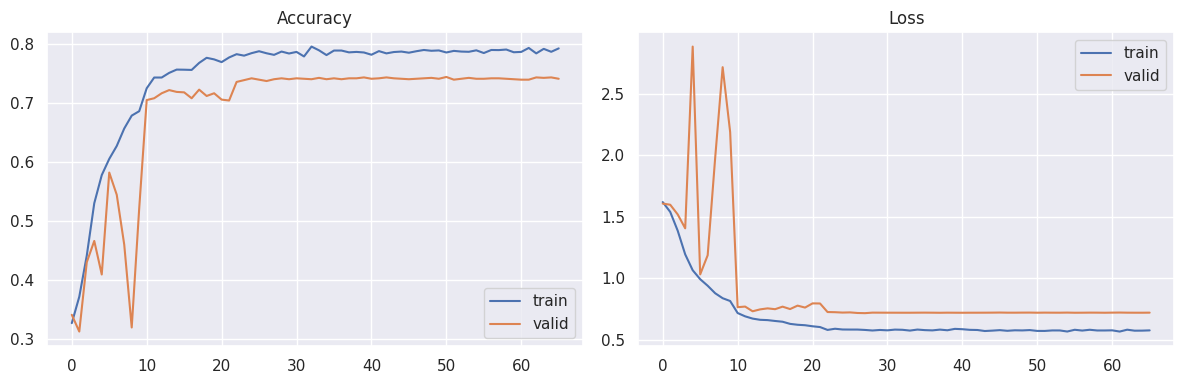

In [ ]:
sns.set()
fig = pyplot.figure(figsize=(12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=history_DenseNet.epoch, y=history_DenseNet.history['accuracy'], label='train')
sns.lineplot(x=history_DenseNet.epoch, y=history_DenseNet.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=history_DenseNet.epoch, y=history_DenseNet.history['loss'], label='train')
sns.lineplot(x=history_DenseNet.epoch, y=history_DenseNet.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.show()

In [ ]:
label_to_text

{0: 'Surprise', 1: 'Fear', 2: 'Angry', 3: 'Neutral', 4: 'Sadness', 5: 'Happy'}

163/163 - 2s - loss: 0.5265 - accuracy: 0.8079 - 2s/epoch - 13ms/step

train Accuracy: 0.8078846335411072
41/41 - 1s - loss: 0.7218 - accuracy: 0.7440 - 549ms/epoch - 13ms/step

Test Accuracy: 0.7440430521965027
41/41 [==============================] - 1s 12ms/step

Classification Report:
               precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        50
        Fear       0.69      0.57      0.63       145
       Happy       0.71      0.74      0.73       188
     Neutral       0.60      0.70      0.65       246
     Sadness       0.60      0.55      0.57       231
    Surprise       0.91      0.90      0.91       441

    accuracy                           0.74      1301
   macro avg       0.75      0.74      0.75      1301
weighted avg       0.75      0.74      0.74      1301



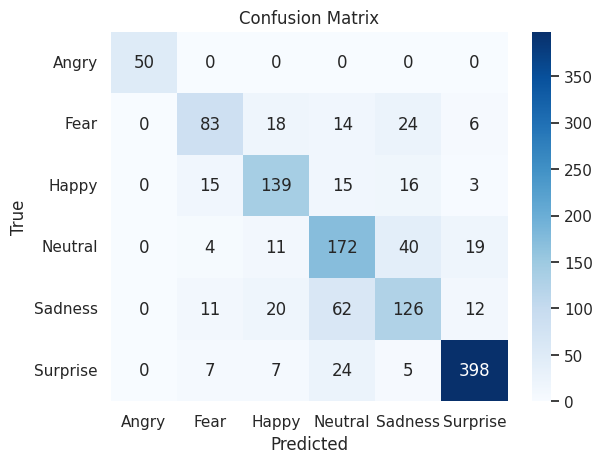

In [ ]:
from sklearn.metrics import confusion_matrix

# Evaluate the model
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(y_test, axis=1)

# Classification Report
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=TOP_EMOTIONS))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=TOP_EMOTIONS, yticklabels=TOP_EMOTIONS)
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted')
pyplot.ylabel('True')
pyplot.show()

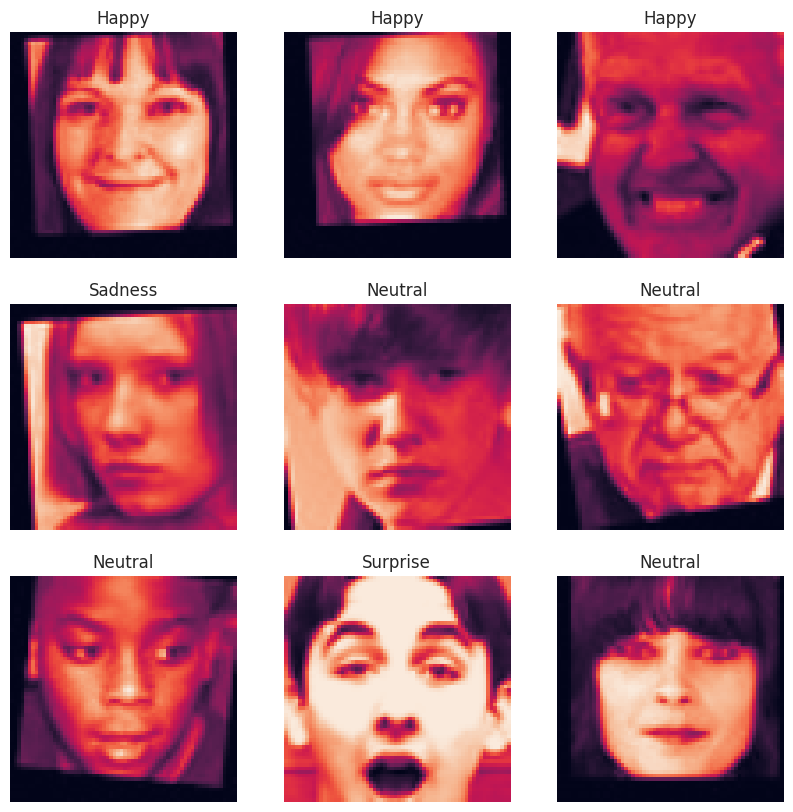

In [ ]:
# Visualize some predictions
pyplot.figure(figsize=(10, 10))
for i in range(9):
    ax = pyplot.subplot(3, 3, i + 1)
    pyplot.imshow(X_test[i])
    pyplot.title(label_to_text[predicted_labels[i]])
    pyplot.axis("off")

pyplot.show()

In [ ]:
pip install visualkeras

  Obtaining dependency information for visualkeras from https://files.pythonhosted.org/packages/a5/93/abd375b37add77d58a8c48a506ae39bb77c4380e2507ea444325ff1b9971/visualkeras-0.0.2-py3-none-any.whl.metadata
  Obtaining dependency information for aggdraw>=1.3.11 from https://files.pythonhosted.org/packages/e4/57/59b42e145ff12941c5c63d59dc48369912a9e29d69966ff630e6f0f815ac/aggdraw-1.3.18.post0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 18.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


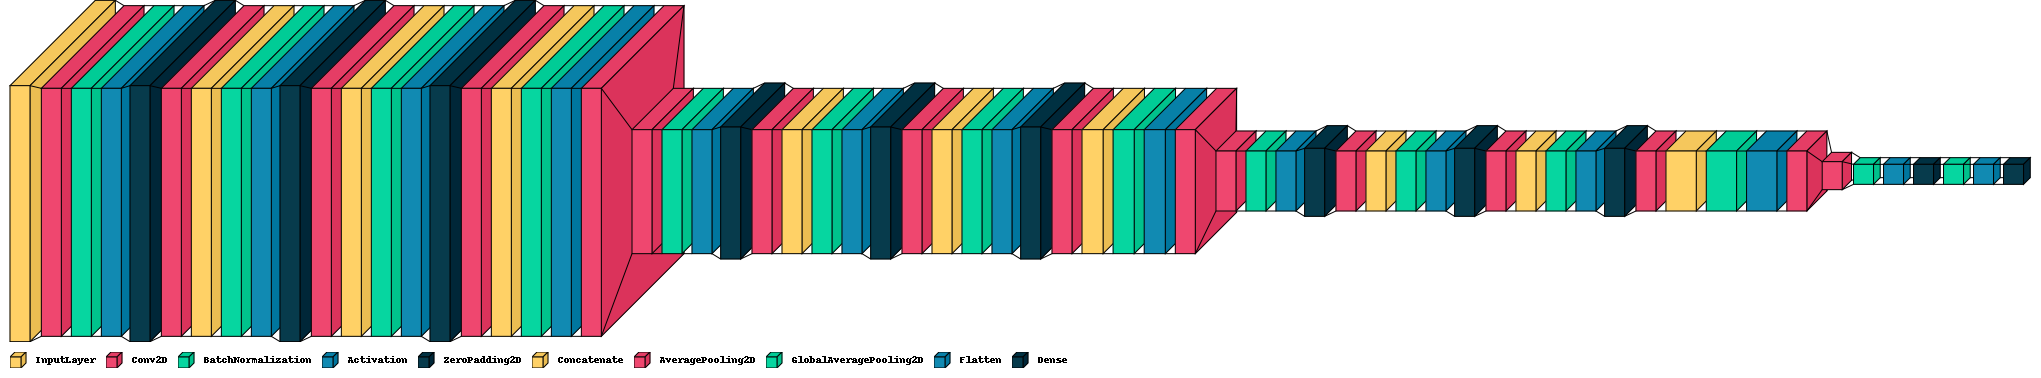

In [ ]:
import visualkeras

visualkeras.layered_view(model, legend=True)